## 1. Setup & Installation

In [1]:
! apt install -y tesseract-ocr
! pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (6,837 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 122531 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3

## 2. Create Custom Handler for Inference Endpoints


In [2]:
%%writefile handler.py
from typing import Dict, List, Any
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor
import torch
from subprocess import run

# install tesseract-ocr and pytesseract
run("apt install -y tesseract-ocr", shell=True, check=True)
run("pip install pytesseract", shell=True, check=True)

# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class EndpointHandler:
    def __init__(self, path=""):
        # load model and processor from path
        self.model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd").to(device)
        self.processor = LayoutLMv2Processor.from_pretrained("philschmid/layoutlm-funsd")

    def __call__(self, data: Dict[str, bytes]) -> Dict[str, List[Any]]:
        """
        Args:
            data (:obj:):
                includes the deserialized image file as PIL.Image
        """
        # process input
        image = data.pop("inputs", data)

        # process image
        encoding = self.processor(image, return_tensors="pt")

        # run prediction
        with torch.inference_mode():
            outputs = self.model(
                input_ids=encoding.input_ids.to(device),
                bbox=encoding.bbox.to(device),
                attention_mask=encoding.attention_mask.to(device),
                token_type_ids=encoding.token_type_ids.to(device),
            )
            predictions = outputs.logits.softmax(-1)

        # post process output
        result = []
        for item, inp_ids, bbox in zip(
            predictions.squeeze(0).cpu(), encoding.input_ids.squeeze(0).cpu(), encoding.bbox.squeeze(0).cpu()
        ):
            label = self.model.config.id2label[int(item.argmax().cpu())]
            if label == "O":
                continue
            score = item.max().item()
            text = self.processor.tokenizer.decode(inp_ids)
            bbox = unnormalize_box(bbox.tolist(), image.width, image.height)
            result.append({"label": label, "score": score, "text": text, "bbox": bbox})
        return {"predictions": result}


Writing handler.py


In [3]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.9 MB/s eta 0:00:00


test custom pipeline

In [4]:
from handler import EndpointHandler

my_handler = EndpointHandler(".")

In [7]:
import base64
from PIL import Image
from io import BytesIO
import json

# read image from disk
image = Image.open("/content/invoice4.jpg")
request = {"inputs":image }

# test the handler
pred = my_handler(request)

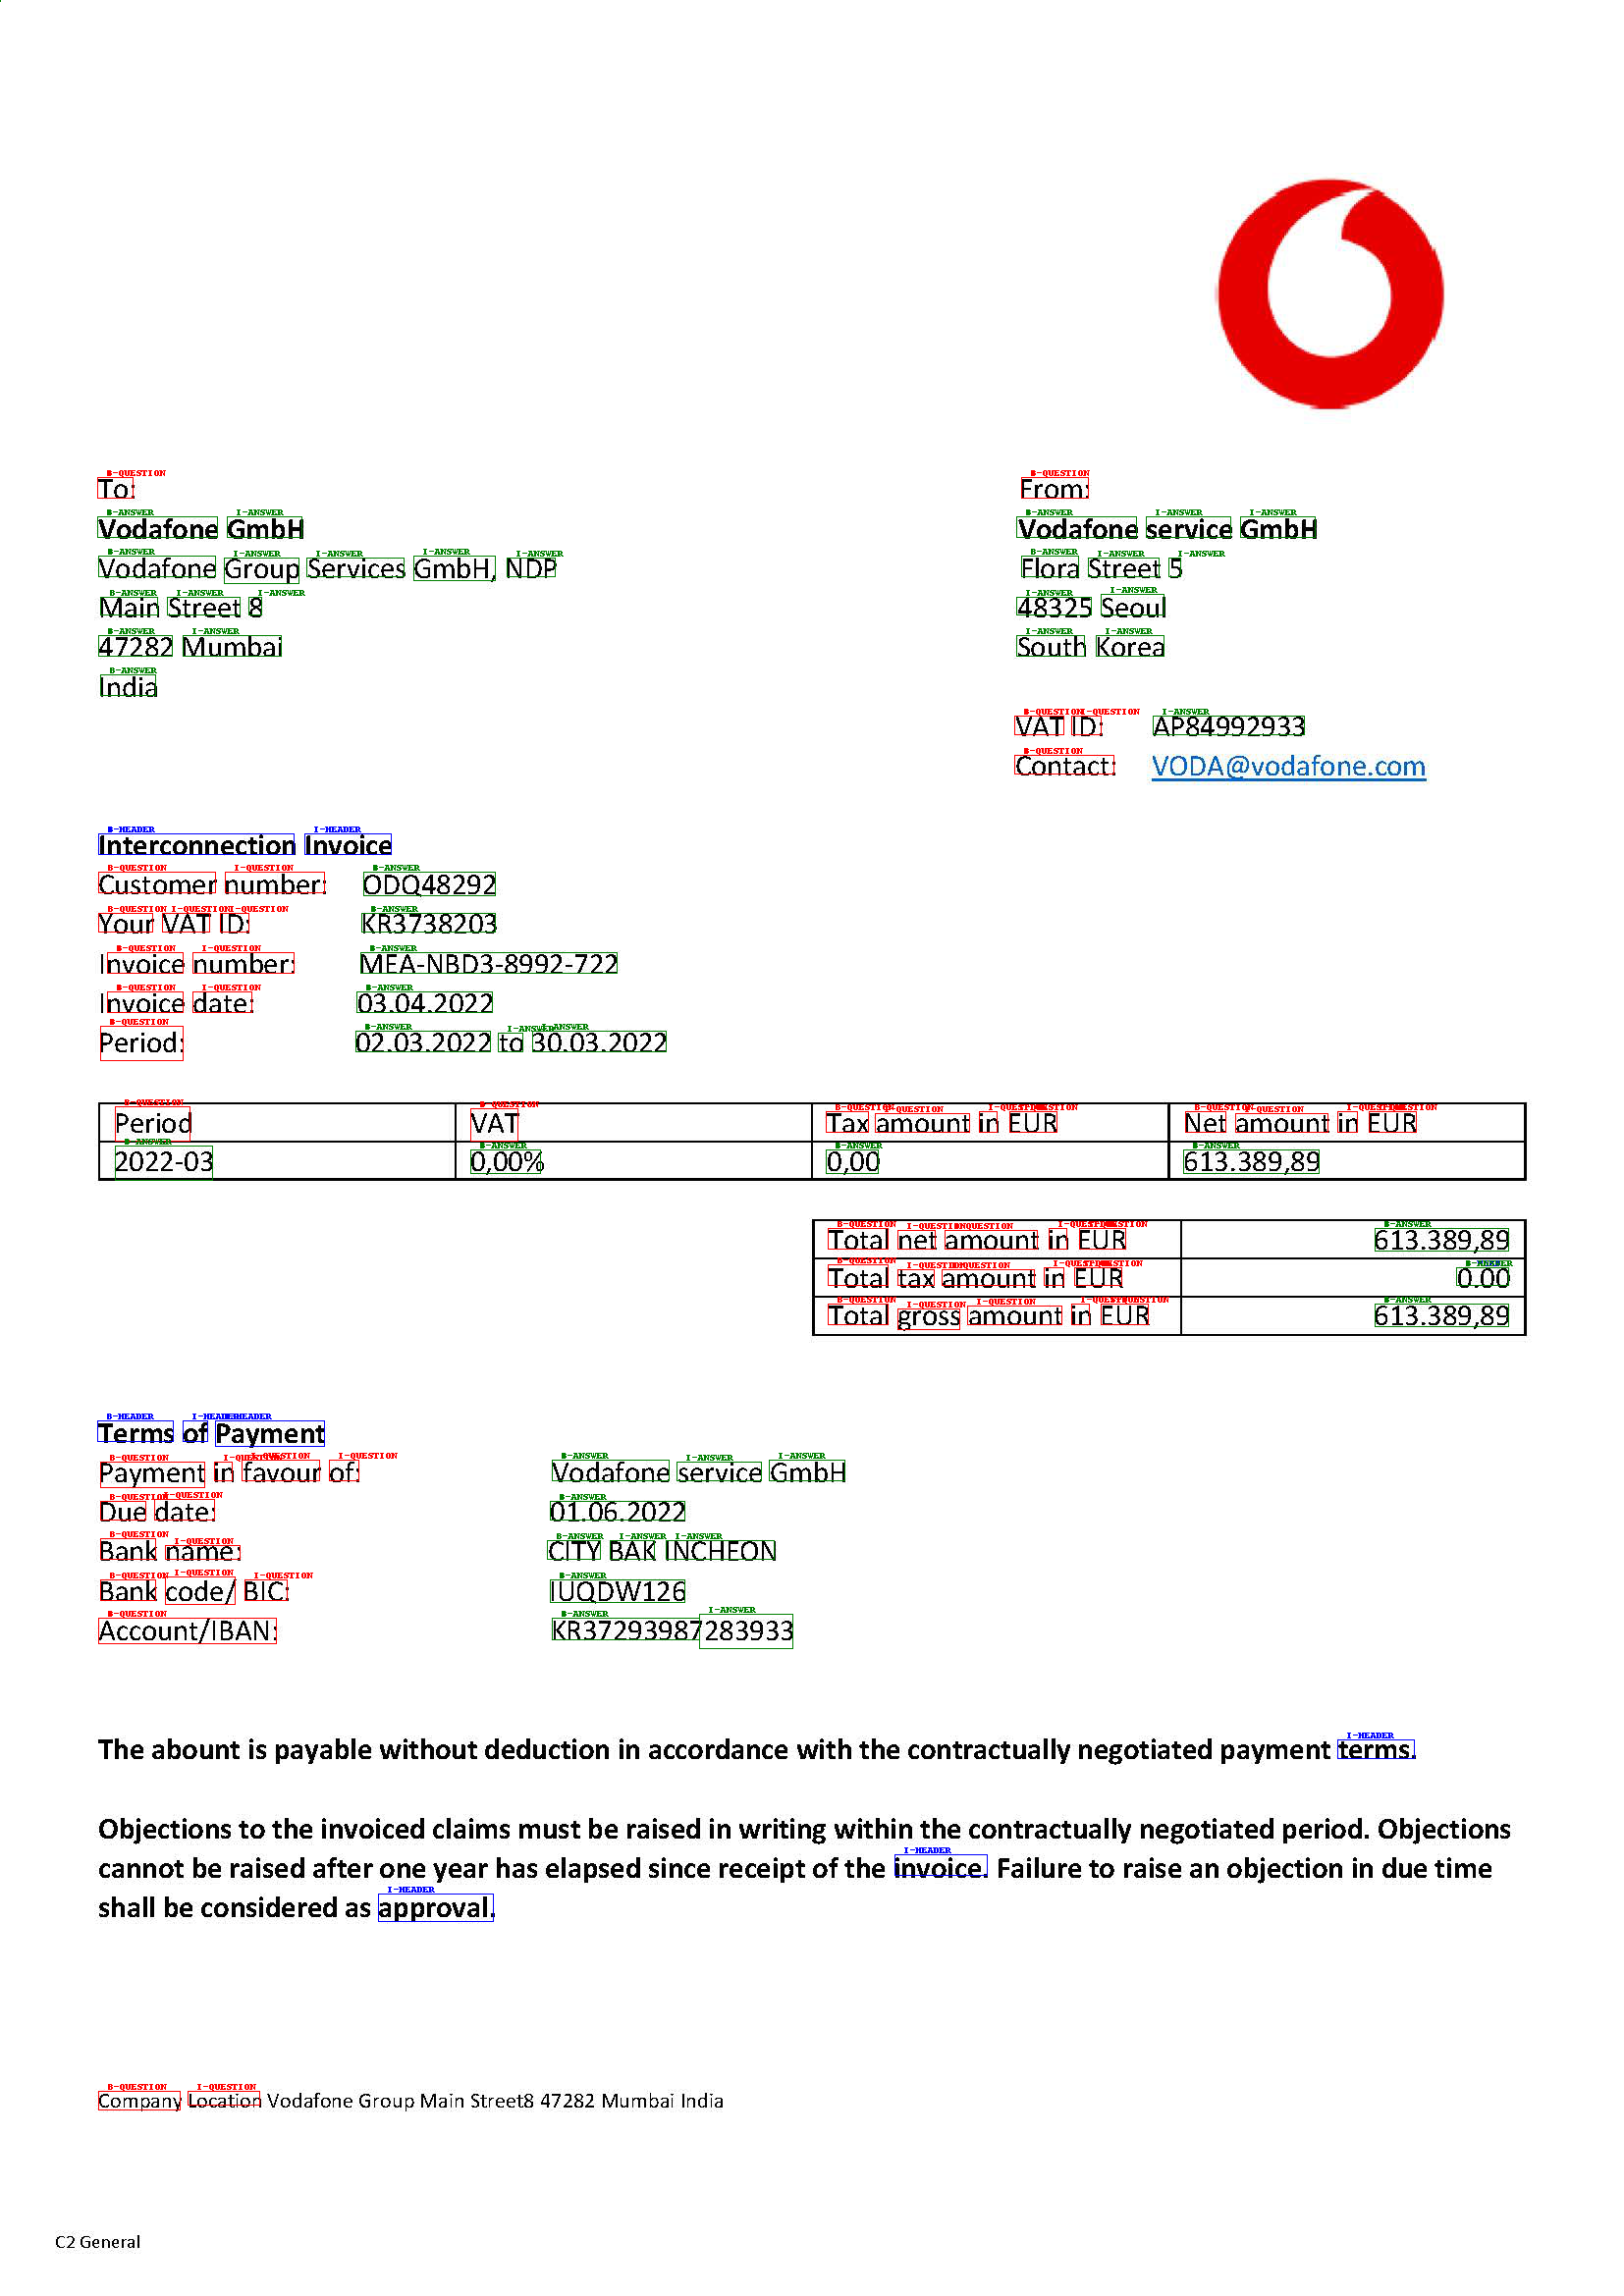

In [9]:
from PIL import Image, ImageDraw, ImageFont


def draw_result(image,result):
    label2color = {
        "B-HEADER": "blue",
        "B-QUESTION": "red",
        "B-ANSWER": "green",
        "I-HEADER": "blue",
        "I-QUESTION": "red",
        "I-ANSWER": "green",
    }


    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for res in result:
        draw.rectangle(res["bbox"], outline="black")
        draw.rectangle(res["bbox"], outline=label2color[res["label"]])
        draw.text((res["bbox"][0] + 10, res["bbox"][1] - 10), text=res["label"], fill=label2color[res["label"]], font=font)
    return image

draw_result(image,pred["predictions"])